In [1]:
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as mp
import matplotlib.colors as mc
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import matplotlib
import scipy.ndimage
import datetime

import itertools
import random
import numpy.random
import scipy.stats
import os

import matplotlib.patches

mp.rcParams.update({'mathtext.default': 'regular'})

from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

degree_sign = u'\u00B0'
% matplotlib inline

In [2]:
model_names = numpy.array(( \
'ACCESS1-0', \
'ACCESS1-3', \
'bcc-csm1-1-m', \
'bcc-csm1-1', \
'BNU-ESM', \
'CanESM2', \
'CCSM4', \
'CESM1-BGC', \
'CESM1-CAM5', \
'CMCC-CESM', \
'CMCC-CM', \
'CMCC-CMS', \
'CNRM-CM5', \
'CSIRO-Mk3-6-0', \
'EC-EARTH', \
'FGOALS-g2', \
'GFDL-CM3', \
'GFDL-ESM2G', \
'GFDL-ESM2M', \
'GISS-E2-H', \
'GISS-E2-R', \
'HadGEM2-AO', \
'HadGEM2-CC', \
'HadGEM2-ES', \
'inmcm4', \
'IPSL-CM5A-LR', \
'IPSL-CM5A-MR', \
'IPSL-CM5B-LR', \
'MIROC5', \
'MIROC-ESM-CHEM', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MPI-ESM-MR', \
'MRI-CGCM3', \
'NorESM1-ME', \
'NorESM1-M' ))
nmods = len(model_names)

In [3]:
pr_lat_lo, pr_lat_hi, pr_lon_lo, pr_lon_hi = 30., 45., 232.5, 248; region = 'CA'
ts_lat_lo, ts_lat_hi, ts_lon_lo, ts_lon_hi = -30., 10., 155., 270.; region = 'tropacific'
ua_lat_lo, ua_lat_hi, ua_lon_lo, ua_lon_hi = 20., 50., 170., 250.; region = 'midlatpacific'
tel_lat_lo, tel_lat_hi, tel_lon_lo, tel_lon_hi = 25., 60., 220., 255.; region = 'CA'

season='djf'; SEASON='DJF'

## use gridspec and custom 3d axis for plotting

In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axis3d import Axis
import matplotlib.pyplot as plt
import matplotlib.projections as proj
from matplotlib.colors import colorConverter

class axis3d_custom(Axis):
    def __init__(self, adir, v_intervalx, d_intervalx, axes, *args, **kwargs):
        Axis.__init__(self, adir, v_intervalx, d_intervalx, axes, *args, **kwargs)
        self.gridline_colors = []
    def set_gridline_color(self, *gridline_info):
        '''Gridline_info is a tuple containing the value of the gridline to change
        and the color to change it to. A list of tuples may be used with the * operator.'''
        self.gridline_colors.extend(gridline_info)
    def draw(self, renderer):
        # filter locations here so that no extra grid lines are drawn
        Axis.draw(self, renderer)
        which_gridlines = []
        if self.gridline_colors:
            locmin, locmax = self.get_view_interval()
            if locmin > locmax:
                locmin, locmax = locmax, locmin

            # Rudimentary clipping
            majorLocs = [loc for loc in self.major.locator() if
                         locmin <= loc <= locmax]
            for i, val in enumerate(majorLocs):
                for colored_val, color in self.gridline_colors:
                    if val == colored_val:
                        which_gridlines.append((i, color))
            colors = self.gridlines.get_colors()
            for val, color in which_gridlines:
                colors[val] = colorConverter.to_rgba(color)
            self.gridlines.set_color(colors)
            self.gridlines.draw(renderer, project=True)

class XAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.xy_dataLim.intervalx

class YAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.xy_dataLim.intervaly

class ZAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.zz_dataLim.intervalx

class Axes3D_custom(Axes3D):
    """
    3D axes object.
    """
    name = '3d_custom'

    def _init_axis(self):
        '''Init 3D axes; overrides creation of regular X/Y axes'''
        self.w_xaxis = XAxis('x', self.xy_viewLim.intervalx,
                            self.xy_dataLim.intervalx, self)
        self.xaxis = self.w_xaxis
        self.w_yaxis = YAxis('y', self.xy_viewLim.intervaly,
                            self.xy_dataLim.intervaly, self)
        self.yaxis = self.w_yaxis
        self.w_zaxis = ZAxis('z', self.zz_viewLim.intervalx,
                            self.zz_dataLim.intervalx, self)
        self.zaxis = self.w_zaxis

        for ax in self.xaxis, self.yaxis, self.zaxis:
            ax.init3d()
proj.projection_registry.register(Axes3D_custom)

## open data

Specify ```DATESTRING``` from file you saved from the ```pareto_calculations*.ipynb``` script

In [5]:
#DATESTRING = '2017-07-24_00:19:58'
DATESTRING = '2018-05-19_12:05:57'

save_dir = '../../DATA/subensemble_data/'
save_filename = 'pareto_front_results_'+DATESTRING+'_k1to5.npy'

save_dict = numpy.load(save_dir+save_filename)

pareto_set_collect_2d_list = save_dict[()]['pareto_set_collect_2d_list']
pareto_set_collect_3d_list = save_dict[()]['pareto_set_collect_3d_list']

bias_values_subensembles_x = save_dict[()]['bias_values_subensembles_x']
bias_values_subensembles_y = save_dict[()]['bias_values_subensembles_y']
bias_values_subensembles_z = save_dict[()]['bias_values_subensembles_z']

bias_values_subensembles_x_LENS = save_dict[()]['bias_values_subensembles_x_LENS']
bias_values_subensembles_y_LENS = save_dict[()]['bias_values_subensembles_y_LENS']
bias_values_subensembles_z_LENS = save_dict[()]['bias_values_subensembles_z_LENS']

col1_orig = numpy.copy(bias_values_subensembles_x)
col2_orig = numpy.copy(bias_values_subensembles_y)
col3_orig = numpy.copy(bias_values_subensembles_z)

#
k = save_dict[()]['k']
N_pareto_loops = save_dict[()]['N_pareto_loops']

N_ens = save_dict[()]['N_ens']
N_ens_LENS = save_dict[()]['N_ens_LENS']

model_combinations = save_dict[()]['model_combinations']
model_combinations_LENS = save_dict[()]['model_combinations_LENS']

dict_x = save_dict[()]['dict_x']
dict_y = save_dict[()]['dict_y']
dict_z = save_dict[()]['dict_z']

pareto_set_sizes_3d = save_dict[()]['pareto_set_sizes_3d']

In [6]:
print(bias_values_subensembles_y_LENS.size)
print(bias_values_subensembles_y.size)

760098
443703


# Printing the full range and 10th to 90th percentile of the rmse

In [7]:
precip_pareto_rmse_vals = pareto_set_collect_3d_list[0][:,0]
precip_ALL_rmse_vals = bias_values_subensembles_x
precip_CMIP5_rmse_vals = dict_x['bias_values_mods']

In [8]:
print(numpy.mean(precip_ALL_rmse_vals), numpy.std(precip_ALL_rmse_vals))
print(numpy.mean(precip_pareto_rmse_vals), numpy.std(precip_pareto_rmse_vals))
print()
print(precip_ALL_rmse_vals.min(), precip_ALL_rmse_vals.max())
print(precip_pareto_rmse_vals.min(), precip_pareto_rmse_vals.max())
print()
print(precip_CMIP5_rmse_vals.min(), precip_CMIP5_rmse_vals.max())
print(precip_CMIP5_rmse_vals.shape)

1.1775648265743097 0.22620789982475972
0.724652250097443 0.10620541593289631

0.5044401894401799 2.9381537059095164
0.5044401894401799 1.2517584917054294

0.6191180036605979 2.9381537059095164
(36,)


In [9]:
print(numpy.percentile(precip_ALL_rmse_vals, 10, interpolation='nearest'))
print(numpy.percentile(precip_ALL_rmse_vals, 90, interpolation='nearest'))
print()
print(numpy.percentile(precip_pareto_rmse_vals, 10, interpolation='nearest'))
print(numpy.percentile(precip_pareto_rmse_vals, 90, interpolation='nearest'))

0.894380857030431
1.4771420639357213

0.6044351314050279
0.8668615121483517


In [10]:
(0.869-0.604)/(2.938-0.619)

0.11427339370418285

# Plot all Pareto front information

plotting 2D combo 1
plotting 2D combo 2
plotting 2D combo 3
plotting 3D combo


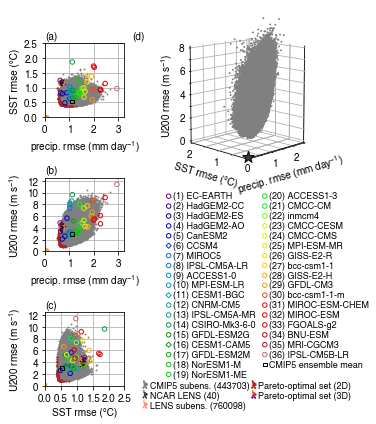

In [16]:
markersize_small = 10
markersize_verysmall = 3
markersize_big = 20
fontsize=10

fig = mp.figure(figsize=(5,6))

xlabel='precip. rmse (mm day$^{-1}$)'
ylabel='SST rmse ('+degree_sign+'C)'
zlabel='U200 rmse (m s$^{-1}$)'

fig_titles = ['','(a)','(b)','(c)','(d)']
titles_instances = []

precip_lim = (0,3.25)
sst_lim = (0,2.5)
u200_lim = (0,12.5)

precip_ticks = [0,1,2,3]
sst_ticks = [0,0.5,1,1.5,2,2.5]
u200_ticks = [0,2,4,6,8,10,12]

pr_error = 0.0816906403487*1.96
sst_error = 0.02964993495*1.96
u200_error = 0.264875178502*1.96

# 1 is precip and SSTs
# 2 is precip and u winds
# 3 is SSTs and winds

for which_combo in [1,2,3]:
    
    pareto_set_collect = pareto_set_collect_2d_list[which_combo-1]
    
    print('plotting 2D combo '+str(which_combo))

    colors = cm.nipy_spectral(numpy.linspace(0.1,1,nmods+1,endpoint=True))
    bias_sort = numpy.argsort(dict_x['bias_values_mods'])
    
    ax = mp.subplot2grid((13,10),((which_combo-1)*4+1,0),colspan=4,rowspan=4)#(2,2,which_combo)

    title = ax.text(s=fig_titles[which_combo],x=0,y=1.03,fontsize=fontsize,ha='left',va='bottom',transform=ax.transAxes)
    titles_instances.append(title)
    # add 3D title that is flush with (a)
    if which_combo==1:
        title = ax.text(s=fig_titles[4],x=1.1,y=1.03,fontsize=fontsize,ha='left',va='bottom',transform=ax.transAxes)
        titles_instances.append(title)
    
    if which_combo==1:
        for i in range(nmods):
            if model_names[bias_sort][i] in ['CESM1-BGC', 'CESM1-CAM5', 'CCSM4']:
                ax.scatter(dict_x['bias_values_mods'][bias_sort][i], dict_y['bias_values_mods'][bias_sort][i], s=markersize_big/1.5, marker='D', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)
            else:
                ax.scatter(dict_x['bias_values_mods'][bias_sort][i], dict_y['bias_values_mods'][bias_sort][i], s=markersize_big, marker='o', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)
    elif which_combo==2:
        for i in range(nmods):
            if model_names[bias_sort][i] in ['CESM1-BGC', 'CESM1-CAM5', 'CCSM4']:
                ax.scatter(dict_x['bias_values_mods'][bias_sort][i], dict_z['bias_values_mods'][bias_sort][i], s=markersize_big/1.5, marker='D', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)
            else:
                ax.scatter(dict_x['bias_values_mods'][bias_sort][i], dict_z['bias_values_mods'][bias_sort][i], s=markersize_big, marker='o', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)
    elif which_combo==3:
        for i in range(nmods):
            if model_names[bias_sort][i] in ['CESM1-BGC', 'CESM1-CAM5', 'CCSM4']:
                ax.scatter(dict_y['bias_values_mods'][bias_sort][i], dict_z['bias_values_mods'][bias_sort][i], s=markersize_big/1.5, marker='D', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)
            else:
                ax.scatter(dict_y['bias_values_mods'][bias_sort][i], dict_z['bias_values_mods'][bias_sort][i], s=markersize_big, marker='o', facecolor='None', edgecolor=colors[i,:], label='('+str(i+1)+') '+ model_names[bias_sort][i], linewidth=1, zorder=5, rasterized=False)

    # MMEM
    if which_combo==1:
        ax.scatter(dict_x['mmem_bias'], dict_y['mmem_bias'], s=markersize_big/1.5, marker='s', edgecolor='0', facecolor='None', label='CMIP5 ensemble mean', linewidth=1, zorder=6, rasterized=False)
        ellipse_plot = matplotlib.patches.Ellipse(xy=[0,0], width=2*pr_error, height=2*sst_error, angle=0, facecolor='orange', edgecolor='darkorange', zorder=1)
        ax.add_artist(ellipse_plot)
    elif which_combo==2:
        ax.scatter(dict_x['mmem_bias'], dict_z['mmem_bias'], s=markersize_big/1.5, marker='s', edgecolor='0', facecolor='None', label='CMIP5 ensemble mean', linewidth=1, zorder=6, rasterized=False)
        ellipse_plot = matplotlib.patches.Ellipse(xy=[0,0], width=2*pr_error, height=2*u200_error, angle=0, facecolor='orange', edgecolor='darkorange', zorder=1)
        ax.add_artist(ellipse_plot)
    elif which_combo==3:
        ax.scatter(dict_y['mmem_bias'], dict_z['mmem_bias'], s=markersize_big/1.5, marker='s', edgecolor='0', facecolor='None', label='CMIP5 ensemble mean', linewidth=1, zorder=6, rasterized=False)
        ellipse_plot = matplotlib.patches.Ellipse(xy=[0,0], width=2*sst_error, height=2*u200_error, angle=0, facecolor='orange', edgecolor='darkorange', zorder=1)
        ax.add_artist(ellipse_plot)
        
    # NCAR LENS INFORMATION
    if (which_combo==1):
        # LENS
        ax.scatter(bias_values_subensembles_x_LENS, bias_values_subensembles_y_LENS, marker='.', s=markersize_verysmall/3, facecolor='coral', color='coral', label='LENS subens. ('+str(N_ens_LENS)+')', zorder=3, rasterized=True) 
        ax.scatter(dict_x['bias_values_LENS'], dict_y['bias_values_LENS'], marker='.', s=markersize_verysmall/3, facecolor='0.1', color='0.1', label='NCAR LENS (40)', zorder=4, rasterized=True) 

    elif (which_combo==2):
        # LENS
        ax.scatter(bias_values_subensembles_x_LENS, bias_values_subensembles_z_LENS, marker='.', s=markersize_verysmall/3, facecolor='coral', color='coral', label='LENS subens. ('+str(N_ens_LENS)+')', zorder=3, rasterized=True) 
        ax.scatter(dict_x['bias_values_LENS'], dict_z['bias_values_LENS'], marker='.', s=markersize_verysmall/3, facecolor='0.1', edgecolor='0.1', label='NCAR LENS (40)', zorder=4, rasterized=True) 

    elif (which_combo==3):
        # LENS
        ax.scatter(bias_values_subensembles_y_LENS, bias_values_subensembles_z_LENS, marker='.', s=markersize_verysmall/3, facecolor='coral', edgecolor='coral', label='LENS subens. ('+str(N_ens_LENS)+')', zorder=3, rasterized=True) 
        ax.scatter(dict_y['bias_values_LENS'], dict_z['bias_values_LENS'], marker='.', s=markersize_verysmall/3, facecolor='0.1', color='0.1', label='NCAR LENS (40)', zorder=4, rasterized=True)         
        
    # SUBENSEMBLES
    if which_combo==1: #xy
        ax.scatter(bias_values_subensembles_x[36:], bias_values_subensembles_y[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(xlabel, size=fontsize)
        ax.set_ylabel(ylabel, size=fontsize)
        ax.set_ylim(sst_lim)
        ax.set_xlim(precip_lim)
        ax.set_xticks(precip_ticks)
        ax.set_yticks(sst_ticks)
    elif which_combo==2:
        ax.scatter(bias_values_subensembles_x[36:], bias_values_subensembles_z[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(xlabel, size=fontsize)
        ax.set_ylabel(zlabel, size=fontsize)
        ax.set_ylim(u200_lim)
        ax.set_xlim(precip_lim)
        ax.set_xticks(precip_ticks)
        ax.set_yticks(u200_ticks)
    elif which_combo==3:
        ax.scatter(bias_values_subensembles_y[36:], bias_values_subensembles_z[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(ylabel, size=fontsize)
        ax.set_ylabel(zlabel, size=fontsize)
        ax.set_xlim(sst_lim)
        ax.set_ylim(u200_lim)
        ax.set_xticks(sst_ticks)
        ax.set_yticks(u200_ticks)
        
    ax.tick_params(labelsize=fontsize)

    ax.scatter(pareto_set_collect[:,0], pareto_set_collect[:,1], marker='.', s=markersize_verysmall, edgecolor='firebrick', facecolor='firebrick', zorder=2, label='Pareto-optimal set (2D)', rasterized=True)

    if which_combo==1:
        handles,labels = ax.get_legend_handles_labels()
        labels = labels[:-4]+[labels[-2]]+[labels[-3]]+[labels[-4]]+[labels[-1]]
        handles = handles[:-4]+[handles[-2]]+[handles[-3]]+[handles[-4]]+[handles[-1]]

    ax.grid()
    ax.set_axisbelow(True)
        
####################################################################################################
####################################################################################################
####################################################################################################

print('plotting 3D combo')

pareto_set_collect = pareto_set_collect_3d_list[0]
ax = mp.subplot2grid((13,10),(0,4),colspan=7,rowspan=7,projection='3d_custom')

# COLORIZING PARETO FRONT
min_val = 0.3
max_val = 0.7
colors = [ [i/(len(pareto_set_sizes_3d)-1)]*pareto_set_sizes_3d[i] for i in range(len(pareto_set_sizes_3d)) ]
colors = numpy.array(([item for sublist in colors for item in sublist]))*(max_val-min_val)+min_val
cmap = mp.get_cmap('inferno')
colors = [cmap(i) for i in colors]

ax.scatter(bias_values_subensembles_x[36:],bias_values_subensembles_y[36:],bias_values_subensembles_z[36:],facecolor='0.5',edgecolor='0.5',marker='.', s=markersize_verysmall, zorder=1, alpha=1, rasterized=True)
ax.scatter(pareto_set_collect[:,0][::-1],pareto_set_collect[:,1][::-1],pareto_set_collect[:,2][::-1],facecolor=colors[::-1],edgecolor=colors[::-1], marker='.', s=markersize_verysmall, alpha=1, zorder=2, rasterized=True, label='Pareto-optimal set (3D)')

xlab = ax.set_xlabel(xlabel, fontsize=fontsize, labelpad=-4)
ylab = ax.set_ylabel(ylabel, fontsize=fontsize, labelpad=-4)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
zlab = ax.set_zlabel(zlabel, fontsize=fontsize, labelpad=-4, rotation=90)

ax.scatter(0,0,0,marker='*',s=150,color='0.25',edgecolor='0')
ax.text(s='0', x=0, y=0, z=-1, fontsize=fontsize, ha='center', va='center')

ax.set_zlim(0,8)
ax.set_xlim(0,2.5)
ax.set_ylim(0,2)

precip_ticks = [0.5,1,1.5,2,2.5]
u200_ticks = [0,1,2,3,4,5,6,7,8]
sst_ticks = [0,0.5,1,1.5,2]

precip_ticklabels = ['','1','','2','']
u200_ticklabels = ['0','','2','','4','','6','','8']
sst_ticklabels = ['','','1','','2']

ax.set_xticks(precip_ticks)
ax.set_yticks(sst_ticks)
ax.set_zticks(u200_ticks)

ax.set_xticklabels(precip_ticklabels)
ax.set_yticklabels(sst_ticklabels)
ax.set_zticklabels(u200_ticklabels)

ax.view_init(10,225) # elevation, azimuthal

ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('None')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('None')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('None')

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('left') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('left') for t in ax.get_zticklabels()]

ax.tick_params(labelsize=fontsize, pad=0)

ax.yaxis.set_gridline_color((0, 'black'))
################################################################################
################################################################################
################################################################################
# create legend #
ax_outer_legend = mp.subplot2grid((13,10),(7,4),colspan=7,rowspan=7, frameon=False) #fig.add_subplot(111, frameon=False)
ax_outer_legend.axes.get_xaxis().set_visible(False)
ax_outer_legend.axes.get_yaxis().set_visible(False)

handles2,labels2 = ax.get_legend_handles_labels()
handles+=handles2
labels+=labels2

N_scatter=15
offsets=numpy.random.normal(loc=0.5, scale=0.25, size=N_scatter)
fig_outer_legend_two = ax_outer_legend.legend(handles[-5:], \
                                          labels[-5:], \
                                          fontsize=fontsize-1, \
                                          ncol=2, \
                                          scatterpoints=N_scatter, \
                                          scatteryoffsets=offsets, \
                                          borderpad=0., \
                                          borderaxespad=0., \
                                          handletextpad=0., \
                                          handlelength=1.0, \
                                          loc='lower center', \
                                          bbox_to_anchor=(0.5,-0.17), \
                                          bbox_transform=ax_outer_legend.transAxes, \
                                          edgecolor='0', framealpha=0, \
                                          columnspacing=0, labelspacing=0.1, fancybox=False)

fig_outer_legend_one = ax_outer_legend.legend(handles[:-5], \
                                          labels[:-5], \
                                          fontsize=fontsize-1, \
                                          ncol=2, \
                                          scatterpoints=1, \
                                          borderpad=0., \
                                          borderaxespad=0., \
                                          handletextpad=-0.5, \
                                          loc='lower left', \
                                          bbox_to_anchor=(-0.1,0.05), \
                                          bbox_transform=ax_outer_legend.transAxes, \
                                          edgecolor='0', framealpha=0, \
                                          columnspacing=0, labelspacing=0.1, fancybox=False)

# change 3D info
cmap_values = offsets*(max_val-min_val)+min_val
fig_outer_legend_two.legendHandles[-1].set_color(cmap(cmap_values))
mp.gca().add_artist(fig_outer_legend_two)

################################################################################
################################################################################
################################################################################

fig.tight_layout(w_pad=2)

fig.savefig('figure_2_pareto_fronts_'+DATESTRING+'_index_LARGE_domains_rasterized_k1to5.pdf', \
            transparent=True, bbox_inches='tight', \
            bbox_extra_artists=[xlab,ylab,zlab]+titles_instances+[fig_outer_legend_one,fig_outer_legend_two], \
            dpi=1200)

In [13]:
print(model_names[bias_sort])

['EC-EARTH' 'HadGEM2-CC' 'HadGEM2-ES' 'HadGEM2-AO' 'CanESM2' 'CCSM4'
 'MIROC5' 'IPSL-CM5A-LR' 'ACCESS1-0' 'MPI-ESM-LR' 'CESM1-BGC' 'CNRM-CM5'
 'IPSL-CM5A-MR' 'CSIRO-Mk3-6-0' 'GFDL-ESM2G' 'CESM1-CAM5' 'GFDL-ESM2M'
 'NorESM1-M' 'NorESM1-ME' 'ACCESS1-3' 'CMCC-CM' 'inmcm4' 'CMCC-CESM'
 'CMCC-CMS' 'MPI-ESM-MR' 'GISS-E2-R' 'bcc-csm1-1' 'GISS-E2-H' 'GFDL-CM3'
 'bcc-csm1-1-m' 'MIROC-ESM-CHEM' 'MIROC-ESM' 'FGOALS-g2' 'BNU-ESM'
 'MRI-CGCM3' 'IPSL-CM5B-LR']


Save the ordering of the biases for plotting in Fig. 4 (to keep numbering system same)

## Plot only Pareto-optimal points

Note in Langenbrunner and Neelin (2017, GRL), Fig. 2 was created by overlaying the 3D Pareto-optimal solutions from the PDF produced below onto the figure above.  This was done because matplotlib's 3D plotting capabilities weren't working well at the time of publication.  See [here](https://stackoverflow.com/questions/23188561/matplotlib-3d-plot-zorder-issue) for info on the specific issue.

plotting 2D combo 1
plotting 2D combo 2
plotting 2D combo 3
plotting 3D combo


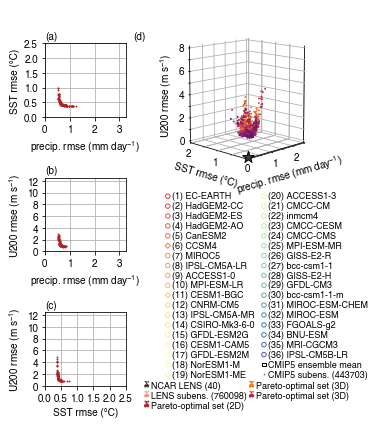

In [15]:
markersize_small = 10
markersize_verysmall = 3
markersize_big = 20
fontsize=10

fig = mp.figure(figsize=(5,6))

xlabel='precip. rmse (mm day$^{-1}$)'
ylabel='SST rmse ('+degree_sign+'C)'
zlabel='U200 rmse (m s$^{-1}$)'

fig_titles = ['','(a)','(b)','(c)','(d)']
titles_instances = []

precip_lim = (0,3.25)
sst_lim = (0,2.5)
u200_lim = (0,12.5)

precip_ticks = [0,1,2,3]
sst_ticks = [0,0.5,1,1.5,2,2.5]
u200_ticks = [0,2,4,6,8,10,12]

pr_error = 0.0816906403487
sst_error = 0.02964993495
u200_error = 1.54937455102

# 1 is precip and SSTs
# 2 is precip and u winds
# 3 is SSTs and winds

for which_combo in [1,2,3]:
    
    pareto_set_collect = pareto_set_collect_2d_list[which_combo-1]
    
    print('plotting 2D combo '+str(which_combo))

    colors = cm.nipy_spectral(numpy.linspace(0,1,nmods+1,endpoint=True))

    bias_sort = numpy.argsort(dict_x['bias_values_mods'])
    
    #ax = fig.add_subplot(2,2,which_combo)
    ax = mp.subplot2grid((13,10),((which_combo-1)*4+1,0),colspan=4,rowspan=4)#(2,2,which_combo)

    title = ax.text(s=fig_titles[which_combo],x=0,y=1.03,fontsize=fontsize,ha='left',va='bottom',transform=ax.transAxes)
    titles_instances.append(title)
    # add 3D title that is flush with (a)
    if which_combo==1:
        title = ax.text(s=fig_titles[4],x=1.1,y=1.03,fontsize=fontsize,ha='left',va='bottom',transform=ax.transAxes)
        titles_instances.append(title)

    # SUBENSEMBLES
    if which_combo==1: #xy
        #ax.scatter(bias_values_subensembles_x[36:], bias_values_subensembles_y[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(xlabel, size=fontsize)
        ax.set_ylabel(ylabel, size=fontsize)
        ax.set_ylim(sst_lim)
        ax.set_xlim(precip_lim)
        ax.set_xticks(precip_ticks)
        ax.set_yticks(sst_ticks)
    elif which_combo==2:
        #ax.scatter(bias_values_subensembles_x[36:], bias_values_subensembles_z[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(xlabel, size=fontsize)
        ax.set_ylabel(zlabel, size=fontsize)
        ax.set_ylim(u200_lim)
        ax.set_xlim(precip_lim)
        ax.set_xticks(precip_ticks)
        ax.set_yticks(u200_ticks)
    elif which_combo==3:
        #ax.scatter(bias_values_subensembles_y[36:], bias_values_subensembles_z[36:], marker='.', s=markersize_verysmall, edgecolor='0.5', facecolor='0.5', zorder=1, label='CMIP5 subens. ('+str(N_ens)+')', rasterized=True)
        ax.set_xlabel(ylabel, size=fontsize)
        ax.set_ylabel(zlabel, size=fontsize)
        ax.set_xlim(sst_lim)
        ax.set_ylim(u200_lim)
        ax.set_xticks(sst_ticks)
        ax.set_yticks(u200_ticks)
        
    ax.tick_params(labelsize=fontsize)

    ax.scatter(pareto_set_collect[:,0], pareto_set_collect[:,1], marker='.', s=markersize_verysmall, edgecolor='firebrick', facecolor='firebrick', zorder=2, label='Pareto-optimal set (2D)', rasterized=False)
    
    ax.grid()
    ax.set_axisbelow(True)
        
####################################################################################################
####################################################################################################
####################################################################################################

print('plotting 3D combo')

pareto_set_collect = pareto_set_collect_3d_list[0]
ax = mp.subplot2grid((13,10),(0,4),colspan=7,rowspan=7,projection='3d_custom')

# COLORIZING PARETO FRONT
min_val = 0.3
max_val = 0.7
colors = [ [i/(len(pareto_set_sizes_3d)-1)]*pareto_set_sizes_3d[i] for i in range(len(pareto_set_sizes_3d)) ]
colors = numpy.array(([item for sublist in colors for item in sublist]))*(max_val-min_val)+min_val
#cmap = mp.get_cmap('YlOrRd_r')
cmap = mp.get_cmap('inferno')
colors = [cmap(i) for i in colors]

#ax.scatter(bias_values_subensembles_x[36:],bias_values_subensembles_y[36:],bias_values_subensembles_z[36:],facecolor='0.5',edgecolor='0.5',marker='.', s=markersize_verysmall, zorder=1, alpha=1, rasterized=True)
ax.scatter(pareto_set_collect[:,0][::-1],\
           pareto_set_collect[:,1][::-1],\
           pareto_set_collect[:,2][::-1],\
           facecolor=colors[::-1],\
           edgecolor=colors[::-1], \
           marker='.', s=markersize_verysmall, \
           alpha=1, zorder=2, rasterized=False, \
           label='Pareto-optimal set (3D)')

xlab = ax.set_xlabel(xlabel, fontsize=fontsize, labelpad=-4)
ylab = ax.set_ylabel(ylabel, fontsize=fontsize, labelpad=-4)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
zlab = ax.set_zlabel(zlabel, fontsize=fontsize, labelpad=-4, rotation=90)

ax.scatter(0,0,0,marker='*',s=150,color='0.25',edgecolor='0')
ax.text(s='0', x=0, y=0, z=-1, fontsize=fontsize, ha='center', va='center')

ax.set_zlim(0,8)
ax.set_xlim(0,2.5)
ax.set_ylim(0,2)

precip_ticks = [0.5,1,1.5,2,2.5]
u200_ticks = [0,1,2,3,4,5,6,7,8]
sst_ticks = [0,0.5,1,1.5,2]

precip_ticklabels = ['','1','','2','']
u200_ticklabels = ['0','','2','','4','','6','','8']
sst_ticklabels = ['','','1','','2']

ax.set_xticks(precip_ticks)
ax.set_yticks(sst_ticks)
ax.set_zticks(u200_ticks)

ax.set_xticklabels(precip_ticklabels)
ax.set_yticklabels(sst_ticklabels)
ax.set_zticklabels(u200_ticklabels)

ax.view_init(10,225) # elevation, azimuthal

ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('None')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('None')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('None')

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('left') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('left') for t in ax.get_zticklabels()]

ax.tick_params(labelsize=fontsize, pad=0)

ax.yaxis.set_gridline_color((0, 'black'))
################################################################################
################################################################################
################################################################################
# create legend #
ax_outer_legend = mp.subplot2grid((13,10),(7,4),colspan=7,rowspan=7, frameon=False) #fig.add_subplot(111, frameon=False)
ax_outer_legend.axes.get_xaxis().set_visible(False)
ax_outer_legend.axes.get_yaxis().set_visible(False)

handles2,labels2 = ax.get_legend_handles_labels()
handles+=handles2
labels+=labels2

N_scatter=15
offsets=numpy.random.normal(loc=0.5, scale=0.25, size=N_scatter)
fig_outer_legend_two = ax_outer_legend.legend(handles[-5:], \
                                          labels[-5:], \
                                          fontsize=fontsize-1, \
                                          ncol=2, \
                                          scatterpoints=N_scatter, \
                                          scatteryoffsets=offsets, \
                                          borderpad=0., \
                                          borderaxespad=0., \
                                          handletextpad=0., \
                                          handlelength=1.0, \
                                          loc='lower center', \
                                          bbox_to_anchor=(0.5,-0.17), \
                                          bbox_transform=ax_outer_legend.transAxes, \
                                          edgecolor='0', framealpha=0, \
                                          columnspacing=0, labelspacing=0.1, fancybox=False)

fig_outer_legend_one = ax_outer_legend.legend(handles[:-5], \
                                          labels[:-5], \
                                          fontsize=fontsize-1, \
                                          ncol=2, \
                                          scatterpoints=1, \
                                          borderpad=0., \
                                          borderaxespad=0., \
                                          handletextpad=-0.5, \
                                          loc='lower left', \
                                          bbox_to_anchor=(-0.1,0.05), \
                                          bbox_transform=ax_outer_legend.transAxes, \
                                          edgecolor='0', framealpha=0, \
                                          columnspacing=0, labelspacing=0.1, fancybox=False)

# change 3D info
cmap_values = offsets*(max_val-min_val)+min_val
fig_outer_legend_two.legendHandles[-1].set_color(cmap(cmap_values))
mp.gca().add_artist(fig_outer_legend_two)

################################################################################
################################################################################
################################################################################

fig.tight_layout(w_pad=2)

fig.savefig('figure_2_pareto_fronts_'+DATESTRING+'_index_LARGE_domains_rasterized_k1to5_PARETO_ONLY.pdf', \
            transparent=True, bbox_inches='tight', \
            bbox_extra_artists=[xlab,ylab,zlab]+titles_instances+[fig_outer_legend_one,fig_outer_legend_two], \
            dpi=1200)